In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q '/content/drive/MyDrive/BTD_DL.zip'

replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

class_1 = os.listdir('/content/yes/')
class_0 = os.listdir('/content/no/')

In [ ]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

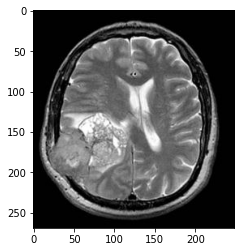

Image size= (269, 249, 3)


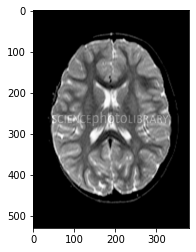

Image size= (530, 380, 3)


In [ ]:
example1 = plt.imread('/content/yes/' + class_1[13])
plt.imshow(example1)
plt.show()
print('Image size=', example1.shape)

example0 = plt.imread('/content/no/' + class_0[54])
plt.imshow(example0)
plt.show()
print('Image size=', example0.shape)

In [ ]:
os.mkdir('/content/train/')
os.mkdir('/content/test/')
os.mkdir('/content/train/yes/')
os.mkdir('/content/train/no/')
os.mkdir('/content/test/yes/')
os.mkdir('/content/test/no/')

FileExistsError: ignored

In [ ]:
import shutil
import random
from sklearn.model_selection import train_test_split
np.random.seed(0)
random.seed(0)
train_1, test_1 = train_test_split(class_1, test_size=0.3,  shuffle = True)
train_0, test_0 = train_test_split(class_0, test_size=0.3, shuffle = True)


for filename in train_1:
    shutil.copy('/content/yes/'+filename, '/content/train/yes/'+filename)

for filename in train_0:
    shutil.copy('/content/no/'+filename, '/content/train/no/'+filename)

for filename in test_1:
    shutil.copy('/content/yes/'+filename, '/content/test/yes/'+filename)

for filename in test_0:
    shutil.copy('/content/no/'+filename, '/content/test/no/'+filename)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train/',
    target_size=(227, 227),
    shuffle = True,
    batch_size=32)

validation_generator = test_datagen.flow_from_directory(
    '/content/test/',
    target_size=(227, 227),
    batch_size=32)

Found 176 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


In [ ]:
os.mkdir('preview')

FileExistsError: ignored

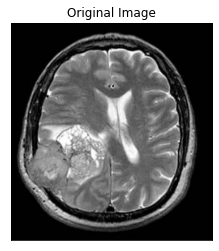

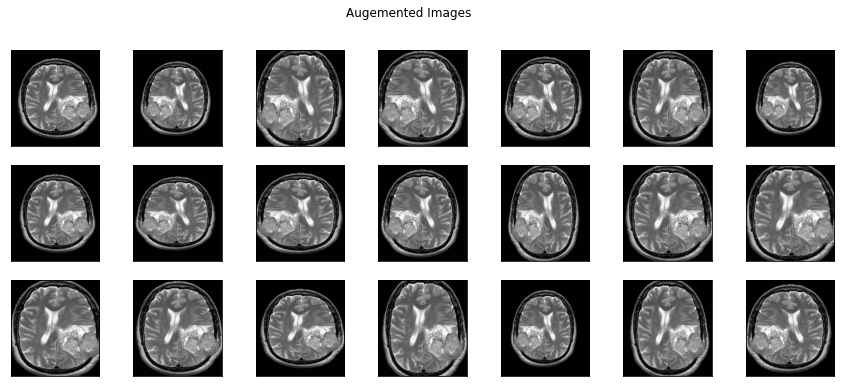

In [ ]:
x = example1  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
plt.imshow(example1)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augmented Images')
plt.show()

In [ ]:
#creating the VGG16 model
vgg = tf.keras.applications.VGG16(
    include_top= False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling= max,
    classes=1,
    classifier_activation="softmax",
)

In [ ]:
# view the structure of the model
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# our layers - you can add more if you want

from keras import layers
NUM_CLASSES = 2

model = Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8194      
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history = model.fit(train_generator,
          epochs=50,
          validation_data=validation_generator)

Epoch 1/50
6/6 [==============================] - 26s 3s/step - loss: 40.0466 - accuracy: 0.5000 - val_loss: 8.6750 - val_accuracy: 0.6104
Epoch 2/50
6/6 [==============================] - 4s 641ms/step - loss: 5.3489 - accuracy: 0.5398 - val_loss: 0.9914 - val_accuracy: 0.3896
Epoch 3/50
6/6 [==============================] - 4s 707ms/step - loss: 1.2622 - accuracy: 0.6307 - val_loss: 0.6772 - val_accuracy: 0.4805
Epoch 4/50
6/6 [==============================] - 4s 705ms/step - loss: 0.7020 - accuracy: 0.6136 - val_loss: 0.5991 - val_accuracy: 0.6104
Epoch 5/50
6/6 [==============================] - 4s 626ms/step - loss: 0.7051 - accuracy: 0.6534 - val_loss: 0.6007 - val_accuracy: 0.6104
Epoch 6/50
6/6 [==============================] - 4s 641ms/step - loss: 0.6196 - accuracy: 0.6591 - val_loss: 0.5101 - val_accuracy: 0.7922
Epoch 7/50
6/6 [==============================] - 4s 641ms/step - loss: 0.5278 - accuracy: 0.7614 - val_loss: 0.4920 - val_accuracy: 0.8052
Epoch 8/50
6/6 [=====

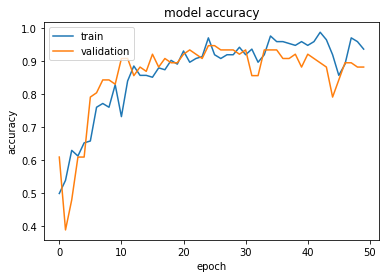

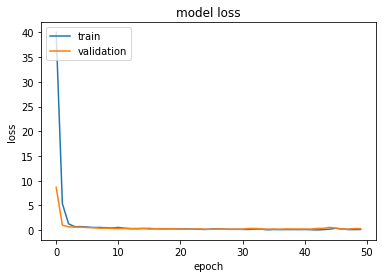

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8194      
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________

In [ ]:
model.evaluate(validation_generator)

3/3 [==============================] - 1s 217ms/step - loss: 0.3163 - accuracy: 0.8831


[0.31625932455062866, 0.8831169009208679]

In [ ]:
model.evaluate(train_generator)

6/6 [==============================] - 3s 445ms/step - loss: 0.1579 - accuracy: 0.9318


[0.15786197781562805, 0.9318181872367859]